In [2]:
#!/usr/bin/env python

import sys
import re
import itertools

import pandas as pd
pd.set_option('display.max_columns', 250)
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

from IPython.display import display

import pysam

In [3]:
from extract_targets import extract_info

In [43]:
pwd

u'/projects/btl2/zxue/tasrkleat/test-results-gmap/utrtargets'

In [4]:
gtf = 'reference/Homo_sapiens.GRCh37.75.gtf'

In [5]:
# http://uswest.ensembl.org/info/website/upload/gff.html
names = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
# adf: annotation df
print('reading {0}...'.format(gtf))
df = pd.read_csv(gtf, header=None, sep='\t', comment='#', low_memory=False, names=names)

reading reference/Homo_sapiens.GRCh37.75.gtf...


In [6]:
extract_info(df)

extracting length...
extracting transcript id...
extracting gene id...
extracting gene name...


### Does target genes overlap at all?

In [7]:
TARGET_GENES = []
with open('./targets-for-tasrkleat/target_genes.txt') as inf:
    for line in inf:
        TARGET_GENES.append(line.strip())

In [8]:
' '.join(TARGET_GENES)

'ABL1 AKT1 AKT2 ALK AMER1 APC ATM AXIN1 BAP1 BCL6 BRAF BRCA1 BRCA2 CARD11 CCND1 CCND2 CCNE1 CD47 CDH1 CDKN2A CDKN2C CEBPA CHURC1 CREBBP CTNNB1 CYLD DICER1 DRAM1 EGFR EP300 ERBB2 EZH2 FAS FBXW7 FGF2 FGFR2 FGFR3 FLT3 GATA3 GNA11 GNAQ GNAS HNF1A HRAS IDH1 IGF2BP1 JUN KDM6A KDR KIT KMT2A KRAS MAP2K1 MAP2K2 MAP2K4 MAX MDM2 MDM4 MEN1 MET MITF MLH1 MSH2 MSH6 MYC MYCL MYCN MYD88 NF1 NF2 NFE2L2 NFE2L3 NFYA NKX2-1 NOTCH1 NOTCH2 NRAS NSUN5 PAX5 PDGFRA PIK3CA PIK3R1 PRKAR1A PTCH1 PTEN RAB10 RB1 REL RET RNF43 RTCA SEC24A SETD2 SMAD4 SMARCA4 SMARCB1 SMO SOCS1 SOX2 STAT3 STK11 STK17A SUFU TERT TET2 TNFAIP3 TP53 TRAF7 TSC1 TSC2 TSHR TXNL4A VHL WT1'

In [10]:
target_df = df.query('gene_name in {0}'.format(TARGET_GENES))
# remove those from unassembled region
target_df = target_df[-target_df.seqname.str.contains('PATCH')]

In [11]:
target_df.head(2)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
63846,1,protein_coding,gene,40361098,40367928,.,-,.,6831,,ENSG00000116990,MYCL
63847,1,protein_coding,transcript,40361098,40367685,.,-,.,6588,ENST00000397332,ENSG00000116990,MYCL


In [12]:
print(target_df.gene_id.unique().shape)
print(target_df.gene_name.unique().shape)

(114,)
(114,)


In [13]:
def check_intersection(grp):
    _df = grp.groupby('gene_name').apply(lambda r: pd.Series([r.start.min(), r.end.max()]))
    _df.columns = ['start', 'end']
    
    has_intersection = False
    for (ki, ri), (kj, rj) in itertools.combinations(_df.iterrows(), 2):
        intersection = set(range(ri.start, ri.end)).intersection(range(rj.start, rj.end))
        if len(intersection) > 0:
            print(ki, ri.start, ri.end, kj, rj.start, rj.end, intersection)
            has_intersection = True
    return has_intersection

In [14]:
target_df.groupby('seqname').apply(check_intersection).any()

False

That it return False means there is no overlap/intersection among those target genes, so the calculation of expression level is straightforward

### Total length of target genes

In [15]:
target_df.gene_name.unique().shape

(114,)

In [16]:
target_gene_coords = target_df.groupby('gene_name').apply(lambda r: pd.Series([r.start.min(), r.end.max()]))
target_gene_coords.rename(columns={0: 'start', 1: 'end'}, inplace=True)
target_gene_coords['len'] = target_gene_coords.end - target_gene_coords.start + 1

In [17]:
target_gene_coords.len.sum()

9351022

###### corroborate with calcuation at the gene level

variable `target_df` doesn't contain feature (e.g. exon, etc) bummer, reprocess a copy of df

In [18]:
ndf = df.copy()

In [19]:
ndf.head(2)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
0,1,pseudogene,gene,11869,14412,.,+,.,2544,,ENSG00000223972,DDX11L1
1,1,processed_transcript,transcript,11869,14409,.,+,.,2541,ENST00000456328,ENSG00000223972,DDX11L1


In [20]:
target_ndf = ndf.query('gene_name in {0}'.format(TARGET_GENES))
# remove those from unassembled region
target_ndf = target_ndf[-target_ndf.seqname.str.contains('PATCH')]

In [21]:
target_ndf.gene_id.unique().shape

(114,)

In [22]:
target_ndf.feature.value_counts()

exon           10341
CDS             7360
UTR             2421
transcript      1191
stop_codon       550
start_codon      544
gene             114
Name: feature, dtype: int64

In [23]:
target_genes = target_ndf.query('feature == "gene"').copy()

In [24]:
target_genes['len'] = target_genes.end - target_genes.start + 1

In [25]:
target_genes.len.sum()

9351022

### Total length of exons of target genes

In [26]:
target_exons = target_ndf.query("feature in ['exon']").copy()

In [27]:
target_exons.feature.unique()

array(['exon'], dtype=object)

In [28]:
target_exons.head()

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
63848,1,protein_coding,exon,40367480,40367685,.,-,.,206,ENST00000397332,ENSG00000116990,MYCL
63851,1,protein_coding,exon,40366611,40367115,.,-,.,505,ENST00000397332,ENSG00000116990,MYCL
63853,1,protein_coding,exon,40361098,40363642,.,-,.,2545,ENST00000397332,ENSG00000116990,MYCL
63859,1,protein_coding,exon,40366611,40367554,.,-,.,944,ENST00000372816,ENSG00000116990,MYCL
63862,1,protein_coding,exon,40362899,40363642,.,-,.,744,ENST00000372816,ENSG00000116990,MYCL


In [29]:
target_exons['len'] = target_exons.end - target_exons.start + 1

In [30]:
target_exons.len.sum()

2546405

In [31]:
target_exons.len.sum() / float(target_genes.len.sum())

0.27231301562545784

### Stop codon counts

In [35]:
stop_codons_df = target_ndf.query('feature == "stop_codon"').groupby(['gene_name']).apply(lambda g: tuple(sorted(g.start.unique()))).rename('start').reset_index()
stop_codons_df['neighbor_dist'] = stop_codons_df.start.apply(lambda v: tuple(np.diff(v).tolist()))
stop_codons_df['num_sc'] = stop_codons_df.start.apply(lambda x: len(x))

In [36]:
stop_codons_df.head(2)

,gene_name,start,neighbor_dist,num_sc
0,ABL1,"(133761068,)",(),1
1,AKT1,"(105235923, 105236678)","(755,)",2


Gene candidates that show differential preference in cleavage site in some cancer types 

In [47]:
df.query('feature == "gene"').query('gene_name in {0}'.format(stop_codons_df.query('num_sc == 1').gene_name.unique().tolist()))

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
81161,1,protein_coding,gene,51426417,51440305,.,+,.,13889,,ENSG00000123080,CDKN2C
280090,2,protein_coding,gene,61108656,61158745,.,+,.,50090,,ENSG00000162924,REL
619894,4,protein_coding,gene,55524085,55606881,.,+,.,82797,,ENSG00000157404,KIT
659930,4,protein_coding,gene,123747863,123819391,.,+,.,71529,,ENSG00000138685,FGF2
1720326,13,protein_coding,gene,32889611,32973805,.,+,.,84195,,ENSG00000139618,BRCA2
1898308,15,protein_coding,gene,66679155,66784650,.,+,.,105496,,ENSG00000169032,MAP2K1
2404484,19,protein_coding,gene,30302805,30315215,.,+,.,12411,,ENSG00000105173,CCNE1


In [45]:
pref_diff_gene_candidates = [
    'BRCA1', 'BRCA2', 'CCNE1', 'CDKN2A', 'CDKN2C', 'CHURC1', 'CYLD',
    'DRAM1', 'EGFR', 'EZH2', 'FGF2', 'FLT3', 'GNAS', 'HNF1A', 'KIT',
    'MAP2K1', 'MAX', 'MDM2', 'MET', 'MITF', 'MYCL', 'PIK3R1', 'PTCH1',
    'REL', 'RNF43', 'STAT3', 'WT1']
stop_codons_df = stop_codons_df.query('gene_name in {0}'.format(pref_diff_gene_candidates)).sort_values('num_sc')

6 Genes from Cell paper https://www.ncbi.nlm.nih.gov/pubmed/19703394

1. ENSG00000100697, DICER1, DICER1
1. ENSG00000110092, CCND1, Cyclin D1
1. ENSG00000084733, RAB10, RAS oncogene family
1. ENSG00000138685, FGF2, Fibroblast growth factor 2
1. ENSG00000118971, CCND2, Cyclin D2
1. ENSG00000159217, IGF2BP1 (aka IMP-1), Insulin-Like Growth Factor 2 MRNA Binding Protein 1

In [40]:
cell_genes = ['CCND1', 'CCND2', 'DICER1', 'FGF2', 'IGF2BP1', 'RAB10']

In [41]:
set(pref_diff_gene_candidates).intersection(set(cell_genes))

{'FGF2'}

In [42]:
stop_codons_df.query('gene_name in {0}'.format(['CCND1', 'CCND2', 'DICER1', 'FGF2', 'IGF2BP1', 'RAB10']))

,gene_name,start,neighbor_dist,num_sc
14,CCND1,"(69462765, 69466048)","(3283,)",2
15,CCND2,"(4409173,)",(),1
26,DICER1,"(95556835, 95556951)","(116,)",2
34,FGF2,"(123813549,)",(),1
45,IGF2BP1,"(47126804,)",(),1
85,RAB10,"(26357888,)",(),1


### Investigating how UTR tail corresponds to Stop codons

In [87]:
def get_cds_utr_iterator(group, strand):
    res = group[group.feature.isin(['CDS', 'UTR'])].sort_values('start')
    if strand == '+':
        return res.iterrows()
    elif strand == '-':
        return res.ix[::-1].iterrows()

def help_func(grp):
    # adopted from https://github.com/bcgsc/utrtargets/blob/master/extract_targets.py
    """get the coordinates of exons that contain 3' UTRs and one extra neighboring
    exon, much more selective than get_coords. The later is preferred, but this
    function is kept for later reference
    """
    # init, U3: 3' UTR
    U3_head = U3_tail = np.NaN
    
    strand = grp.strand.values[0]

    tip = 'end' if strand == '+' else 'start'
    _sr = grp.query('feature == "stop_codon"')[tip]
    if _sr.shape[0] > 0:
        stop_codon_tail = _sr.values[0]
    else:
        stop_codon_tail = np.NaN
    
    state = '5UTR'              # starting from 5' UTR
    U3s = []
    for idx, row in get_cds_utr_iterator(grp, strand):
        if row.feature == 'CDS':
            state = 'CDS'
        else:
            if state == '5UTR':
                pass
            elif state == 'CDS' or '3UTR':
                state == '3UTR'
                U3s.append((row.start, row.end))
    if len(U3s) > 0:
        if strand == '+':
            U3_head = min(itertools.chain(*U3s))
            U3_tail = max(itertools.chain(*U3s))
        else:
            U3_head = max(itertools.chain(*U3s))
            U3_tail = min(itertools.chain(*U3s))
    return pd.Series((stop_codon_tail, U3_head, U3_tail))

In [88]:
stop_codon_utr_df = target_ndf.query('feature != "gene"').groupby(
    ['gene_name', 'strand', 'transcript_id']).apply(
    help_func).rename(
    columns={0:'stop_codon_tail', 1:'UTR_head', 2:'UTR_tail'}).sort_values('UTR_tail')
stop_codon_utr_df = stop_codon_utr_df.reset_index()
stop_codon_utr_df.shape

(1191, 6)

In [89]:
stop_codon_utr_df.sort_values(['gene_name', 'UTR_tail'], inplace=True)

In [90]:
stop_codon_utr_df['UTR_tail_neighbour_dist'] = stop_codon_utr_df.UTR_tail.diff()

Show an example

In [91]:
stop_codon_utr_df.query('gene_name == "TERT"').fillna('-').applymap(lambda x: '{:.0f}'.format(x) if isinstance(x, float) else x)

,gene_name,strand,transcript_id,stop_codon_tail,UTR_head,UTR_tail,UTR_tail_neighbour_dist
11,TERT,-,ENST00000310581,1253843,1253842,1253282,-
12,TERT,-,ENST00000296820,1266627,1266626,1253289,7
13,TERT,-,ENST00000460137,1266627,1266626,1253843,554
14,TERT,-,ENST00000508104,1266627,1266626,1266565,12722
1138,TERT,-,ENST00000334602,1253843,-,-,-
1139,TERT,-,ENST00000484238,-,-,-,-
1140,TERT,-,ENST00000503656,-,-,-,-
1141,TERT,-,ENST00000522877,-,-,-,-


Visualize them

working on CDKN2A...
working on CHURC1...
working on EZH2...
working on MITF...
working on TERT...
working on WT1...


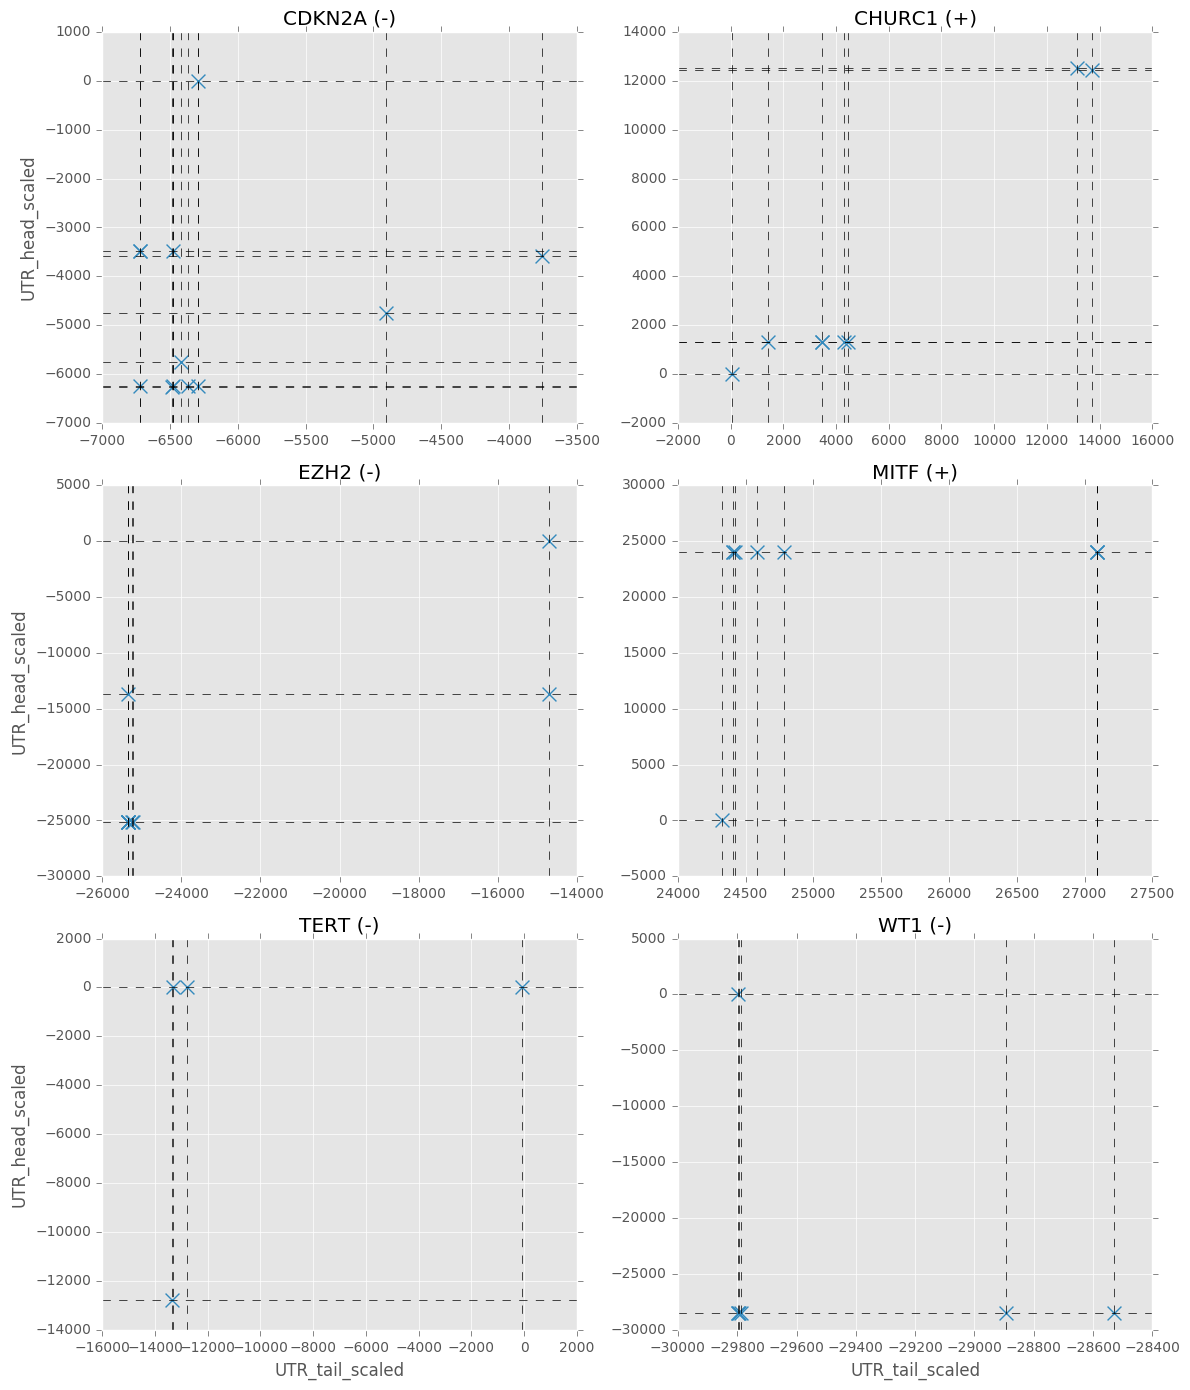

In [92]:
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(12, 14))
axes = axes.ravel()


muti_stop_codon_genes = sorted(['CHURC1', 'MITF', 'TERT', 'WT1', 'EZH2', 'CDKN2A'])
for k, current_gene in enumerate(muti_stop_codon_genes):
    print('working on {0}...'.format(current_gene))
    _su_df = stop_codon_utr_df.query('gene_name == "{0}"'.format(current_gene)).copy()
    strand = _su_df.strand.unique()[0]
    if strand == '+':
        offset = _su_df['UTR_head'].min()
    else:
        offset = _su_df['UTR_head'].max()
#     _su_df['UTR_head_scaled'] = (_su_df.UTR_head - offset).abs()
#     _su_df['UTR_tail_scaled'] = (_su_df.UTR_tail - offset).abs()
    _su_df['UTR_head_scaled'] = (_su_df.UTR_head - offset)
    _su_df['UTR_tail_scaled'] = (_su_df.UTR_tail - offset)

    # start plotting
    
    ax = axes[k]
#     _su_df.plot.scatter(ax=ax, x='UTR_head_scaled', y='UTR_tail_scaled', 
#                         alpha=1, edgecolor='black', linewidth=1, marker='x', s=100)

    _su_df.plot.scatter(ax=ax, x='UTR_tail_scaled',  y='UTR_head_scaled',
                        alpha=1, edgecolor='black', linewidth=1, marker='x', s=100)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    for i in _su_df.UTR_head_scaled.unique():
        ax.plot(xlim, [i, i], '--', color='black', alpha=1, lw=.5)

    for i in _su_df.UTR_tail_scaled.unique():
        ax.plot([i, i], ylim, '--', color='black', alpha=1, lw=.5)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title('{0} ({1})'.format(current_gene, strand))
    if k % 2 != 0:
        ax.set_ylabel('')
    if k < len(muti_stop_codon_genes) - 2:
        ax.set_xlabel('')

plt.tight_layout()
plt.savefig('multi-codon-gene-visualization.png', dpi=200)

# UTR end counts

In [93]:
def extract_utr_ends_per_gene(grp):
    return np.sort(grp.groupby('transcript_id').apply(calc_utr_end_per_transcript).unique())

def calc_utr_end_per_transcript(grp):
    if grp.strand.unique()[0] == '+':
        return max(grp.end.unique())
    else:
        return min(grp.start.unique())

In [94]:
# test case for ENSG00000068078, FGFR3
_test_grp = target_ndf.query('feature == "UTR"').groupby(['gene_id', 'gene_name']).get_group(('ENSG00000068078', 'FGFR3'))
assert extract_utr_ends_per_gene(_test_grp).tolist() == [1810592, 1810598, 1810599]

In [95]:
utr_ends_df = target_ndf.query('feature == "UTR"').groupby(['gene_id', 'gene_name']).apply(extract_utr_ends_per_gene).rename('end').reset_index()
utr_ends_df['len'] = utr_ends_df['end'].apply(lambda x: len(x))

Gene candidates that show differential preference in cleavage site in some cancer types 

In [96]:
# pref_diff_gene_candidates = ['CCNE1', 'CDKN2A', 'EZH2', 'FGF2', 'FGFR3', 'MITF', 'PIK3CA', 'REL', 'SOX2', 'VHL']
pref_diff_gene_candidates = ['CCNE1', 'CDKN2A', 'CHURC1', 'EZH2', 'FGF2', 'MITF', 'REL', 'TERT', 'WT1']
utr_ends_df[utr_ends_df.gene_name.isin(pref_diff_gene_candidates)].sort_values('gene_name')

,gene_id,gene_name,end,len
21,ENSG00000105173,CCNE1,"[30303462, 30314917, 30315119, 30315214, 30315...",5
75,ENSG00000147889,CDKN2A,"[21967751, 21967752, 21967990, 21967995, 21968...",12
113,ENSG00000258289,CHURC1,"[65397655, 65399038, 65401103, 65401913, 65402...",7
24,ENSG00000106462,EZH2,"[148504475, 148504476, 148504477, 148504574, 1...",6
64,ENSG00000138685,FGF2,"[123816619, 123819391]",2
105,ENSG00000187098,MITF,"[69812992, 69915441, 69928336, 70014721, 70014...",11
82,ENSG00000162924,REL,"[61150119, 61158745]",2
84,ENSG00000164362,TERT,"[1253282, 1253289, 1253843, 1266565]",4
101,ENSG00000184937,WT1,"[32409321, 32409324, 32409330, 32410225, 32410...",7


6 Genes from Cell paper https://www.ncbi.nlm.nih.gov/pubmed/19703394

1. ENSG00000100697, DICER1, DICER1
1. ENSG00000110092, CCND1, Cyclin D1
1. ENSG00000084733, RAB10, RAS oncogene family
1. ENSG00000138685, FGF2, Fibroblast growth factor 2
1. ENSG00000118971, CCND2, Cyclin D2
1. ENSG00000159217, IGF2BP1 (aka IMP-1), Insulin-Like Growth Factor 2 MRNA Binding Protein 1

In [97]:
utr_ends_df[utr_ends_df.gene_name.isin(['CCND1', 'CCND2', 'DICER1', 'FGF2', 'IGF2BP1', 'RAB10'])]

,gene_id,gene_name,end,len
11,ENSG00000084733,RAB10,[26360323],1
18,ENSG00000100697,DICER1,"[95552565, 95552566, 95556658, 95556805, 95556...",7
30,ENSG00000110092,CCND1,"[69463008, 69469242]",2
39,ENSG00000118971,CCND2,"[4407134, 4414516]",2
64,ENSG00000138685,FGF2,"[123816619, 123819391]",2
81,ENSG00000159217,IGF2BP1,[47133012],1


In [98]:
current_gene = 'EZH2'

In [99]:
target_ndf.head()

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
63846,1,protein_coding,gene,40361098,40367928,.,-,.,6831,,ENSG00000116990,MYCL
63847,1,protein_coding,transcript,40361098,40367685,.,-,.,6588,ENST00000397332,ENSG00000116990,MYCL
63848,1,protein_coding,exon,40367480,40367685,.,-,.,206,ENST00000397332,ENSG00000116990,MYCL
63849,1,protein_coding,CDS,40367480,40367560,.,-,0,81,ENST00000397332,ENSG00000116990,MYCL
63850,1,protein_coding,start_codon,40367558,40367560,.,-,0,3,ENST00000397332,ENSG00000116990,MYCL


In [100]:
target_ndf.query('feature == "transcript"').query('gene_name == "{0}"'.format(current_gene)).transcript_id.unique()

array(['ENST00000492143', 'ENST00000478654', 'ENST00000460911',
       'ENST00000350995', 'ENST00000320356', 'ENST00000541220',
       'ENST00000476773', 'ENST00000483967', 'ENST00000469631',
       'ENST00000498186', 'ENST00000483012', 'ENST00000536783'], dtype=object)

In [101]:
target_ndf.query('feature == "transcript"').query('gene_name == "{0}"'.format(current_gene))

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
1030802,7,nonsense_mediated_decay,transcript,148504475,148581375,.,-,.,76901,ENST00000492143,ENSG00000106462,EZH2
1030845,7,protein_coding,transcript,148504476,148581251,.,-,.,76776,ENST00000478654,ENSG00000106462,EZH2
1030890,7,protein_coding,transcript,148504477,148581337,.,-,.,76861,ENST00000460911,ENSG00000106462,EZH2
1030935,7,protein_coding,transcript,148504477,148581340,.,-,.,76864,ENST00000350995,ENSG00000106462,EZH2
1030978,7,protein_coding,transcript,148504477,148581370,.,-,.,76894,ENST00000320356,ENSG00000106462,EZH2
1031023,7,protein_coding,transcript,148504477,148581370,.,-,.,76894,ENST00000541220,ENSG00000106462,EZH2
1031066,7,protein_coding,transcript,148504574,148580601,.,-,.,76028,ENST00000476773,ENSG00000106462,EZH2
1031109,7,protein_coding,transcript,148504617,148581379,.,-,.,76763,ENST00000483967,ENSG00000106462,EZH2
1031154,7,retained_intron,transcript,148507292,148508915,.,-,.,1624,ENST00000469631,ENSG00000106462,EZH2
1031157,7,retained_intron,transcript,148514449,148581379,.,-,.,66931,ENST00000498186,ENSG00000106462,EZH2


In [102]:
target_ndf.query('feature == "UTR"').query('gene_name == "{0}"'.format(current_gene))

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
1030833,7,nonsense_mediated_decay,UTR,148581256,148581375,.,-,.,120,ENST00000492143,ENSG00000106462,EZH2
1030834,7,nonsense_mediated_decay,UTR,148544391,148544397,.,-,.,7,ENST00000492143,ENSG00000106462,EZH2
1030835,7,nonsense_mediated_decay,UTR,148516070,148516130,.,-,.,61,ENST00000492143,ENSG00000106462,EZH2
1030836,7,nonsense_mediated_decay,UTR,148513776,148515209,.,-,.,1434,ENST00000492143,ENSG00000106462,EZH2
1030837,7,nonsense_mediated_decay,UTR,148512598,148512638,.,-,.,41,ENST00000492143,ENSG00000106462,EZH2
1030838,7,nonsense_mediated_decay,UTR,148512006,148512131,.,-,.,126,ENST00000492143,ENSG00000106462,EZH2
1030839,7,nonsense_mediated_decay,UTR,148511051,148511229,.,-,.,179,ENST00000492143,ENSG00000106462,EZH2
1030840,7,nonsense_mediated_decay,UTR,148508717,148508812,.,-,.,96,ENST00000492143,ENSG00000106462,EZH2
1030841,7,nonsense_mediated_decay,UTR,148507425,148507506,.,-,.,82,ENST00000492143,ENSG00000106462,EZH2
1030842,7,nonsense_mediated_decay,UTR,148506402,148506482,.,-,.,81,ENST00000492143,ENSG00000106462,EZH2


### Trying to disambiguate belongings of clv sites for FGFR3, MITF, EZH2, CDKN2A

In [103]:
# target_ndf.feature.value_counts()



# kleat_detected_sites = {
#     'FGFR3': [1810582, 1810607],
#     'MITF': [70014710, 70014730, 70014790, 70014809, 70014827, 70014966, 70014986, 70015171, 70015190, 70017471, 70017488, 70017505],
# #     'EZH2': [148504461, 148504484, 148504566, 148504586, 148504605, 148504625, 148515120, 148515140]
#     'EZH2': [148504484, 148504566, 148515140],
#     'CDKN2A': [21967741, 21967765, 21967979, 21968003, 21968040, 21968060, 21968095, 21968115, 21968169, 21968190, 21969556, 21969578, 21970706, 21970725]
# }

# cols_to_drop = ['source', 'feature', 'score', 'frame']
# genes = kleat_detected_sites.keys()
# df_tr = target_ndf.query('feature == "transcript"').query('gene_name in {0}'.format(genes)).drop(cols_to_drop, axis=1)
# df_st = target_ndf.query('feature == "utr_end"').query('gene_name in {0}'.format(genes)).drop(cols_to_drop, axis=1)
# df_trst = df_tr.merge(df_st, on=['seqname', 'gene_name', 'gene_id', 'strand', 'transcript_id'], suffixes=['_transcript', '_utr_end'])

# transcripts_assignment = []
# for key, grp in df_trst.groupby(['gene_name']):
#     gene_name = key
#     for site in kleat_detected_sites[gene_name]:
#         if grp.strand.unique()[0] == '+':
#             tid = grp.loc[np.argmin(np.abs(grp['end_transcript'] - site + 1))].transcript_id
#         else:
#             tid = grp.loc[np.argmin(np.abs(site - grp['start_transcript'] + 1))].transcript_id
#         transcripts_assignment.append((gene_name, tid, site))

# assigned = pd.DataFrame(transcripts_assignment, columns=['gene_name', 'transcript_id', 'clv_site'])

# assigned.shape

# merged = assigned.merge(df_trst, on=['gene_name', 'transcript_id'])

# def calc_utr_len(row):
#     if row.strand == '+':
#         return row.clv_site - row.end_utr_end + 1
#     else:
#         return row.start_utr_end - row.clv_site + 1

# merged['utr_len'] = merged.apply(calc_utr_len, axis=1)

# merged[['gene_name', 'clv_site', 'utr_len']].sort_values('clv_site')

In [104]:
# candidate_transcripts = []
# for start in start_vals:
#     _df = target_ndf[target_ndf.transcript_id.isin(target_ndf.query('feature == "utr_end"').query('start == {0}'.format(start)).transcript_id.values)].query('feature == "transcript"')
#     dd = _df.loc[_df.end.argmax()][['transcript_id', 'start', 'end']].to_dict()
#     dd.update({'start_of_utr_end': start})
#     candidate_transcripts.append(dd)
# candidate_transcripts



# curr_gene = 'CDKN2A'

# detected_sites = kleat_detected_sites[curr_gene]

# start_vals = utr_ends_df.query('gene_name == "{0}"'.format(curr_gene)).start.values[0]
# start_vals

# candidate_transcripts = []
# for start in start_vals:
#     _df = target_ndf[target_ndf.transcript_id.isin(target_ndf.query('feature == "utr_end"').query('start == {0}'.format(start)).transcript_id.values)].query('feature == "transcript"')
#     dd = _df.loc[_df.end.argmax()][['transcript_id', 'start', 'end']].to_dict()
#     dd.update({'start_of_utr_end': start})
#     candidate_transcripts.append(dd)
# candidate_transcripts

# for site in detected_sites:
#     print(site),
#     for trpt in candidate_transcripts:
#         # deuau: dist to end of annotated UTR
# #         print('UTR len: {0}, deuau: {1}'.format(site - trpt['start_of_utr_end'], trpt['end'] - site)), '\t',
#         print('UTR len: {0}, deuau: {1}'.format(site - trpt['start_of_utr_end'], trpt['start'] - site)), '\t',
#     print

In [105]:
# # curr_gene = 'FGFR3'
# curr_gene = 'MITF'

# detected_sites = kleat_detected_sites[curr_gene]

# start_vals = utr_ends_df.query('gene_name == "{0}"'.format(curr_gene)).start.values[0]
# start_vals

# candidate_transcripts = []
# for start in start_vals:
#     _df = target_ndf[target_ndf.transcript_id.isin(target_ndf.query('feature == "utr_end"').query('start == {0}'.format(start)).transcript_id.values)].query('feature == "transcript"')
#     dd = _df.loc[_df.end.argmax()][['transcript_id', 'end']].to_dict()
#     dd.update({'start_of_utr_end': start})
#     candidate_transcripts.append(dd)
# candidate_transcripts

# 70014397 - 69990392

# for site in detected_sites:
#     for trpt in candidate_transcripts:
#         # deuau: dist to end of annotated UTR
#         print('CS: {0}, UTR len: {1}, deuau: {2}'.format(site, site - trpt['start_of_utr_end'], trpt['end'] - site)), '\t',
#     print